In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from datahandling import BcomMEG

In [3]:
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
epo_files = []
subjects = ['BCOM_18_2', 'BCOM_18_3', 'BCOM_18_4']
avoid_reading = False
data = BcomMEG(dir=dir, subjects=subjects, avoid_reading=avoid_reading)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_i_16-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_me_34-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_re_144-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
8 matching events found
No baseline correcti

In [ ]:
# first, sepreate out the conditions
a_labels = []
e_labels = []
i_labels = []
for subject in data.data.keys():
    for condition in data.data[subject].keys():
        if 'a' in condition:
            a_labels.append(condition)
        elif 'e' in condition:
            e_labels.append(condition)
        elif 'i' in condition:
            i_labels.append(condition)

a_labels = set(a_labels)
i_labels = set(i_labels)
e_labels = set(e_labels)

a_epochs = []
e_epochs = []
i_epochs = []

for subject in data.data:
    a_epochs.append(mne.concatenate_epochs([data.data[subject][a] for a in a_labels if a in data.data[subject].keys()]))
    e_epochs.append(mne.concatenate_epochs([data.data[subject][e] for e in e_labels if e in data.data[subject].keys()]))
    i_epochs.append(mne.concatenate_epochs([data.data[subject][i] for i in i_labels if i in data.data[subject].keys()]))

a_epochs = mne.concatenate_epochs(a_epochs) #dev head t differs error when doing all 3 - need a way to correct for this. They suggest maxwell filter. OK but what are the parameters? 
e_epochs = mne.concatenate_epochs(e_epochs)
i_epochs = mne.concatenate_epochs(i_epochs)

Not setting metadata
105 matching events found
No baseline correction applied
Not setting metadata
54 matching events found
No baseline correction applied
Not setting metadata
73 matching events found
No baseline correction applied
Not setting metadata
44 matching events found
No baseline correction applied
Not setting metadata
39 matching events found
No baseline correction applied
Not setting metadata
46 matching events found
No baseline correction applied
Not setting metadata
53 matching events found
No baseline correction applied
Not setting metadata
31 matching events found
No baseline correction applied
Not setting metadata
46 matching events found
No baseline correction applied


ValueError: epochs[1].info['dev_head_t'] differs. The instances probably come from different runs, and are therefore associated with different head positions. Manually change info['dev_head_t'] to avoid this message but beware that this means the MEG sensors will not be properly spatially aligned. See mne.preprocessing.maxwell_filter to realign the runs to a common head position.

In [52]:
from mne.stats import permutation_cluster_test

permuataion_collection = [a_epochs.get_data(), e_epochs.get_data(), i_epochs.get_data()]
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(permuataion_collection, n_permutations=2000, tail=0)

Using a threshold of 3.043980
stat_fun(H1): min=2.5895308760466117e-05 max=9.295301215841619
Running initial clustering …
Found 677 clusters


/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_80135/2382917169.py:4: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(permuataion_collection, n_permutations=2000, tail=0)


  0%|          | Permuting : 0/1999 [00:00<?,       ?it/s]

In [131]:
significant_sensors = np.where(cluster_p_values < 0.05)[0]

In [132]:
significant_sensors

array([], dtype=int64)

### 10 Best sensors based on mutual information

In [101]:
from sklearn.feature_selection import mutual_info_classif

num_a = len(a_epochs)
num_e = len(e_epochs)
num_i = len(i_epochs)
min_trials = (min(num_a, num_e, num_i))

a_rand = a_epochs[np.random.choice(num_a, min(num_a, num_e, num_i), replace=False)]
e_rand = e_epochs[np.random.choice(num_e, min(num_a, num_e, num_i), replace=False)]
i_rand = i_epochs[np.random.choice(num_i, min(num_a, num_e, num_i), replace=False)]

a_data = a_rand.get_data()
e_data = e_rand.get_data()
i_data = i_rand.get_data()

a_flat = a_data.reshape(a_data.shape[0], -1)
e_flat = e_data.reshape(e_data.shape[0], -1)
i_flat = i_data.reshape(i_data.shape[0], -1)


X = np.vstack([a_flat, e_flat, i_flat])
y = np.concatenate([np.ones(min_trials), np.ones(min_trials)*2, np.ones(min_trials)*3])
mi_scores = mutual_info_classif(X, y, random_state=0)
important_sensors = np.argsort(mi_scores)[-10:]



In [102]:
mi_reshaped = mi_scores.reshape(a_data.shape[1], a_data.shape[2])
sensor_mi_scores_reshaped = mi_reshaped.mean(axis=1)
important_sensors = np.argsort(sensor_mi_scores_reshaped)[-10:]
sensor_names = a_epochs.info['ch_names']
important_sensor_names = [sensor_names[i] for i in important_sensors]
print(important_sensor_names)
sensor_mi_scores_reshaped[important_sensors]


['MEG 051', 'MEG 200', 'MEG 118', 'MEG 236', 'MEG 139', 'MEG 161', 'MEG 237', 'MEG 179', 'MEG 067', 'MEG 167']


array([0.01491599, 0.01496312, 0.01498509, 0.01506316, 0.01529511,
       0.01532743, 0.0153836 , 0.01568076, 0.01578509, 0.01588645])

(<matplotlib.image.AxesImage at 0x35df587d0>, None)

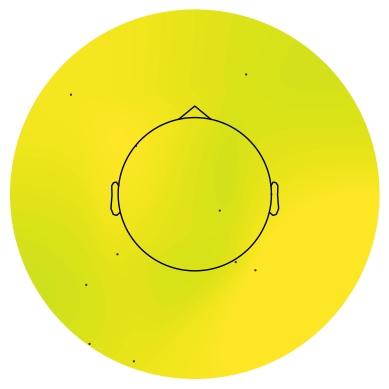

In [103]:
import mne.channels


important_sensor_names
sensor_mi_scores_reshaped[important_sensors]

info = a_epochs.info
picks = mne.pick_channels(info['ch_names'], include=important_sensor_names)

pos = mne.channels.layout._find_topomap_coords(info, picks)

data = np.array(sensor_mi_scores_reshaped[important_sensors])

fig, ax = plt.subplots()
mne.viz.plot_topomap(data, pos, axes=ax, show=False, cmap='viridis', contours=0)

## Ok so where in the brain?

In [ ]:
import os
subject_dir = os.path.expanduser('~/mne_data/MNE-fsaverage-data')
bem_dir = os.path.expanduser('~/mne_data/MNE-fsaverage-data/')
# head transformation, need to use average because no MRIs
transformation = 'fsaverage'

# standard source space and BEM model - "Boundary Element Method" model. i.e., a realistic head model to use for source localization. 
# apparently it deifnes the el

src = mne.setup_source_space(subject='fsaverage', spacing='oct6', subjects_dir=subject_dir) # 5 mins

bem = mne.make_bem_model(subject='fsaverage', subjects_dir=bem_dir) 

bem = mne.make_bem_solution(bem)

# only for the chosen sensors

picks = mne.pick_channels(info['ch_names'], include=important_sensor_names)

# forward model

fwd = mne.make_forward_solution(info=a_epochs.info, trans=transformation, src=src, bem=bem, eeg=False)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~35.0 MB>
MRI -> head transform : /opt/homebrew/Caskroom/miniconda/base/envs/mne/lib/python3.12/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read 247 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.994570 -0.096133 -0.039854      -2.40 mm
    0.101937 0.977019 0.187196     -35.72 m

In [121]:
# get it for only certain channels

picks = mne.pick_channels(fwd['info']['ch_names'], include=important_sensor_names)
fwd_selected = mne.pick_channels_forward(fwd, include=important_sensor_names)

    10 out of 247 channels remain after picking


In [ ]:
# Computing the inverse model:

noise_cov = mne.compute_covariance(a_epochs, method='auto')

# create an inverse operator to convert signals to brain activity

inv = mne.minimum_norm.make_inverse_operator(info=a_epochs.info, forward=fwd_selected, noise_cov=noise_cov)

Reducing data rank from 247 -> 247
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 28197
log-likelihood on unseen data (descending order):
   shrunk: -1368.100
   empirical: -1368.259
   diagonal_fixed: -1427.716
selecting best estimator: shrunk
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 10 channels.
    10 out of 10 channels remain after picking
Selected 10 channels
Creating the depth weighting matrix...
    10 magnetometer or axial gradiometer channels
    limit = 7980/8196 = 10.006894
    scale = 4.5008

In [5]:
# computing source esitmation

lambda2 = 1.0 / 9.0 # regularization parameter
method = "dSPM" # or "dSPM"

stc = mne.minimum_norm.apply_inverse(a_epochs.average(), inv, lambda2, method)

NameError: name 'inv' is not defined

Hmmm... Idk if this shows what I want it to show...

In [82]:
brain = stc.plot(hemi='split', subjects_dir=subject_dir, subject='fsaverage', time_viewer=True)

Using control points [3.26156745 3.43162634 4.04986332]


qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x17bd27a50> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3d2827b40> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x160490780> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x160491b10> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x160496630> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x160497860> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x1604981b0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1

In [39]:
peak_vertex, peak_time = stc.get_peak()
print(f"Peak activation at vertex {peak_vertex} at {peak_time} seconds")

Peak activation at vertex 86178 at 0.21666666666666673 seconds


In [120]:
import mne
import numpy as np

# Read labels for fsaverage (Desikan-Killiany "aparc" parcellation)
labels = mne.read_labels_from_annot(
    subject='fsaverage', 
    parc='aparc', 
    subjects_dir=subject_dir
)

# one of them is missing i guess?
labels = [label for label in labels if 'unknown' not in label.name]

# Extract mean time course from each label
label_ts = mne.extract_label_time_course(
    stc, 
    labels, 
    src=src, 
    mode='mean'
)
# label_ts: shape (n_labels, n_times)

# Find label with largest mean activity over time
mean_act = np.mean(np.abs(label_ts), axis=1)
max_idx = np.argmax(mean_act)
print("Label with strongest average activity:", labels[max_idx].name)

# Also, you can visualize a label-based summary
stc_label = mne.labels_to_stc(
    labels, mean_act, 
    subject='fsaverage'
)
brain = stc_label.plot(
    subject='fsaverage', 
    subjects_dir=subject_dir, 
    hemi='split', 
    time_viewer=True,
    clim={'kind': 'value', 'pos_lims': [0, 0.5, 1]}
)

Reading labels from parcellation...
   read 35 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Extracting time courses for 68 labels (mode: mean)
Label with strongest average activity: lateraloccipital-lh


Well maybe the MI makes sense on just the raw sensor data. But maybe it would make more sense to look at it in terms of the coefficients.